In [1]:
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from joblib import Parallel, delayed

from src.world_cup_simulator import *

In [2]:
def run_group_stage_simulation(n, j):
    teams_pd = pd.read_csv("data/roster.csv")
    
    for i in range(n):
        games = read_games("data/matches.csv")
        teams = {}
    
        for row in [item for item in csv.DictReader(open("data/roster.csv"))]:
            teams[row['team']] = {'name': row['team'], 'rating': float(row['rating']), 'points': 0}
    
        simulate_group_stage(games, teams, ternary=True)
    
        collector = []
        for key in teams.keys():
            collector.append({"team": key, f"simulation{i+1}": teams[key]['points']})

        temp = pd.DataFrame(collector)
        teams_pd = pd.merge(teams_pd, temp)
    
    sim_cols = [a for a in teams_pd.columns if "simulation" in a]
    teams_pd[f"avg_pts_{j+1}"] = teams_pd[sim_cols].mean(axis=1)
    not_sim = [b for b in teams_pd.columns if "simulation" not in b]
    simulation_result = teams_pd[not_sim]
    
    return simulation_result

### Simulate group stage

#### The gist is to read from two files: One defining the match schedule, the other with teams and their relative strengths (given by Elo ratings prior to the start of the event)

In [3]:
# Reads in the matches and teams as dictionaries and proceeds with that data type
n = 100 # How many simulations to run
m = 10 # How many simulation results to collect

roster_pd = Parallel(n_jobs=5)(delayed(run_group_stage_simulation)(n, j) for j in tqdm(range(m)))

for t in tqdm(range(m)):
    if t == 0:
        roster = pd.merge(roster_pd[t], roster_pd[t+1])
    elif t >= 2:
        roster = pd.merge(roster, roster_pd[t])
    else:
        pass

100%|██████████| 10/10 [00:00<00:00, 410.79it/s]


In [ ]:
sim_cols = [i for i in roster.columns if "avg_pts" in i]

In [ ]:
roster['avg_sim_pts'] = roster[sim_cols].mean(axis=1)
roster['99%CI_low'] = roster[sim_cols].quantile(q=0.005, axis=1)
roster['99%CI_high'] = roster[sim_cols].quantile(q=0.995, axis=1)

In [ ]:
not_sim = [j for j in roster.columns if "avg_pts" not in j]

In [ ]:
roster[not_sim].sort_values(by=['group', 'avg_sim_pts'], ascending=False)

### Simulating playoffs

In [2]:
playoff_games_pd = pd.read_csv("data/playoff_matches1.csv")
playoff_teams_pd = pd.read_csv("data/playoff_roster1.csv")

In [7]:
# Now, doing the Monte Carlo simulations
n = 10
m = 10000
fraction_collect = []

for k in tqdm(range(m)):
    
    playoff_results_teams = []
    playoff_results_stage = []
    
    for i in range(n):
        overall_result_teams = dict()
        overall_result_stage = dict()
        games = read_games("data/playoff_matches1.csv")
        teams = {}
    
        for row in [item for item in csv.DictReader(open("data/playoff_roster1.csv"))]:
            teams[row['team']] = {'name': row['team'], 'rating': float(row['rating'])}
    
        simulate_playoffs(games, teams, ternary=True)
    
        playoff_pd = pd.DataFrame(games)
    
        # # This is for collecting results of simulations per team
        # for key in teams.keys():
        #     overall_result_teams[key] = collect_playoff_results(key, playoff_pd)
        # playoff_results_teams.append(overall_result_teams)
    
        # # Now, collecting results from stage-perspective
        # overall_result_stage['whole_bracket'] = playoff_pd['advances'].to_list()
        # overall_result_stage['Quarterfinals'] = playoff_pd.loc[playoff_pd['stage'] == 'eigths_finals', 'advances'].to_list()
        # overall_result_stage['Semifinals'] = playoff_pd.loc[playoff_pd['stage'] == 'quarterfinals', 'advances'].to_list()
        # overall_result_stage['Final'] = playoff_pd.loc[playoff_pd['stage'] == 'semifinals', 'advances'].to_list()
        # overall_result_stage['third_place_match'] = playoff_pd.loc[playoff_pd['stage'] == 'semifinals', 'loses'].to_list()
        overall_result_stage['fourth_place'] = playoff_pd.loc[playoff_pd['stage'] == 'third_place', 'loses'].to_list()[0]
        overall_result_stage['third_place'] = playoff_pd.loc[playoff_pd['stage'] == 'third_place', 'advances'].to_list()[0]
        overall_result_stage['second_place'] = playoff_pd.loc[playoff_pd['stage'] == 'final', 'loses'].to_list()[0]
        overall_result_stage['Champion'] = playoff_pd.loc[playoff_pd['stage'] == 'final', 'advances'].to_list()[0]
        # overall_result_stage['match8'] = list(playoff_pd.loc[8, ['home_team', 'away_team']])
        # overall_result_stage['match9'] = list(playoff_pd.loc[9, ['home_team', 'away_team']])
        # overall_result_stage['match10'] = list(playoff_pd.loc[10, ['home_team', 'away_team']])
        # overall_result_stage['match11'] = list(playoff_pd.loc[11, ['home_team', 'away_team']])
        # overall_result_stage['match12'] = list(playoff_pd.loc[12, ['home_team', 'away_team']])
        # overall_result_stage['match13'] = list(playoff_pd.loc[13, ['home_team', 'away_team']])
        # overall_result_stage['match14'] = list(playoff_pd.loc[14, ['home_team', 'away_team']])
        # overall_result_stage['match15'] = list(playoff_pd.loc[15, ['home_team', 'away_team']])
    
        playoff_results_stage.append(overall_result_stage)
        
    results_stage = pd.DataFrame(playoff_results_stage)
    fraction_collect.append(results_stage['Champion'].value_counts(normalize=True)[0])

100%|██████████| 10000/10000 [02:52<00:00, 58.08it/s]


In [8]:
np.mean(fraction_collect), np.percentile(fraction_collect, [0.5, 50,  99.5])

(0.65086, array([0.5, 0.6, 1. ]))

(array([1922.,    0., 3574.,    0., 2588.,    0., 1397.,    0.,  450.,
          69.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 10 artists>)

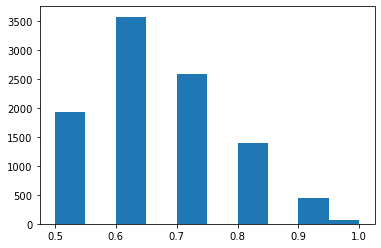

In [9]:
import matplotlib.pyplot as plt
plt.hist(fraction_collect)

In [10]:
results_teams = pd.DataFrame(playoff_results_teams)

In [11]:
results_teams['Argentina'].value_counts()

KeyError: 'Argentina'

In [ ]:
results_stage = pd.DataFrame(playoff_results_stage)

In [ ]:
results_stage['Champion'].value_counts(normalize=True)[0]

In [ ]:
results_stage['Champion']